In [1]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['base_time_dep','distance','rain','temp','day'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(100,100),verbose=True)
                from sklearn.preprocessing import normalize
                
 
            #if mode == 'validate':
            #   if self.regr_type == 'Neural':
                    #self.validate_neural()
            #   else:
                    #self.validate_model()
            #lif mode == 'production':
                #self.build_full_model()
                #self.dump_model()
    def validate_neural(self):
        print('training regressor')
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('Validating...')
        print(metrics.r2_score(self.test_1_Y,preds))
        preds = self.model.predict(self.test_2_X)
        print(metrics.r2_score(self.test_2_Y,preds))
        print('calculated from norms-->')
        preds = preds * self.test_2_norm
        print(metrics.r2_score(self.test_2_real,preds))
        preds = self.model.predict(self.test_3_X)
        print(metrics.r2_score(self.test_3_Y,preds))
    def validate_model(self):
        self.data = self.data[self.data['traveltime']>0] 
        if self.verbose:
            print('Validating model on all trips...\n\n')
        
        self.train = self.data[self.data['year']==2016]
        self.test = self.data[self.data['year']==2017]
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('-----> Tested on all distances')
        print('R2:', metrics.r2_score(self.test_1_Y,preds))
        print('MAE:', metrics.mean_absolute_error(self.test_1_Y,preds)*self.norm[-1])
        print('MAPE:', ((abs(self.test_1_Y-preds)/self.test_1_Y)*100).mean())
        #add more options for testing eventually
        print('Validating model on longest trip')
        test2= self.test[self.test['distance']==self.test['distance'].max()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].max()]
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        print('\n\n Validated on median trip -->')
        test2= self.test[self.test['distance']==self.test['distance'].median()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].median()]
        
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        del(self.train)
        del(self.test)
        del(self.data)
        del(test2)


    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        #if self.use_dummies:
        #    self.add_dummies()
        #    self.features += self.dummy_features
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','routeid','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid','routeid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep'] 
        #A number of rows have negative travel time. But its a really small number, so I guess they 
        #can go in the bin.
        self.data = self.data[self.data['traveltime']>0]
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['dt'].dt.hour
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['day','month','hour'])
        self.dummy_features = [col for col in self.data.columns\
                                if (col[0:3] == 'day' and col != 'dayofservice')\
                                or col[0:5] == 'month' or col[0:4] == 'hour']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [2]:
r = BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather


In [3]:
train = r.data[r.data['year']==2016]
test = r.data[r.data['year']==2017]

In [4]:
from sklearn.preprocessing import StandardScaler as ss

In [5]:
scaler_X = ss()
X = scaler_X.fit_transform(train[r.features])

In [6]:
scaler_Y = ss()
Y = scaler_Y.fit_transform(train['traveltime'].values.reshape(-1,1))

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
model = r.rgr.fit(X,Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.02272909
Iteration 2, loss = 0.01751099
Iteration 3, loss = 0.01703897
Iteration 4, loss = 0.01675823
Iteration 5, loss = 0.01656698
Iteration 6, loss = 0.01636375
Iteration 7, loss = 0.01621540
Iteration 8, loss = 0.01609528
Iteration 9, loss = 0.01597149
Iteration 10, loss = 0.01587479
Iteration 11, loss = 0.01578446
Iteration 12, loss = 0.01570935
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


In [9]:
preds = scaler_Y.inverse_transform(model.predict(X))
((abs(train['traveltime']-preds)/train['traveltime'])*100).mean()

14.072097906339566

# Scores are surprisingly good when we test the whole model

In [22]:
real_Y = test['traveltime']
X = scaler_X.transform(test[r.features])
preds = scaler_Y.inverse_transform(model.predict(X))
print(((abs(real_Y-preds)/real_Y)*100).mean())
print(metrics.r2_score(real_Y,preds))

15.510186481608578
0.9598387189573916


In [23]:
# but...
preds[preds < 0].shape[0]

7454

In [25]:
preds.min()

-381.41314984724613

## On closer inspection though

In [12]:
distances = sorted(test['distance'].unique())
ds = []
r2 = []
mape = []
for i in range(0,len(distances)-1):
    distance1 = distances[i]
    distance2 = distances[i+1]
    X = test[(test['distance']>=distance1) & (test['distance'] < distance2)]
    real_Y = X['traveltime']
    X = scaler_X.transform(X[r.features])
    preds =  scaler_Y.inverse_transform(model.predict(X))
    ds.append(distance1)
    from sklearn import metrics
    r2.append(metrics.r2_score(real_Y,preds))
    mape.append(((abs(real_Y - preds)/real_Y)*100).mean())
    print(preds.min())
    
    


-381.41314984724613
-350.169072457159
-283.6341356073981
-98.9221599881198
-97.4236317900536
-54.45525035938681
-3.970649454357499
40.45507277896013
90.1213707445495
133.96146680985885
158.46151759609074
182.51269544153502
219.64226086544522
231.60567735124732
255.48778990276924
272.4290450122048
303.3910498648238
330.2432626671566
356.9721910205701
382.2096873793423
404.9946039603576
429.7952157249647
470.9910180973752
502.0118519555647
534.433136061343
562.1416052825339
594.1429807726536
625.9565636945206
665.0007559326859
696.9508329940477
761.3807477769676
1314.4597302178224
1247.3428669052573
1296.6470941701684
1431.5393107063078
1544.276407690942
1646.7254980752084
1731.4053680080508
1773.2312333886446
1819.5079076682218
1845.0955243525927
1869.3207225536426
1895.4526721691132
1918.9915000519184
1952.6857666379387
1991.0190190766189
2015.4267718013277
2048.1223360155227
2178.7865668184118
2207.724070381647
2127.3850458988036
2155.8255050083
2188.958049450196
2219.090685215465
224

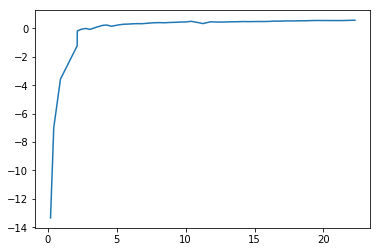

In [18]:
from matplotlib import pyplot as plt
plt.plot(ds,r2)
plt.show()

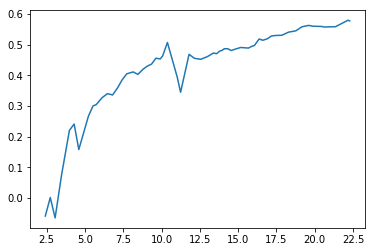

In [17]:
from matplotlib import pyplot as plt
plt.plot(ds[5:],r2[5:])
plt.show()

In [16]:
max(r2)

0.579678378096769

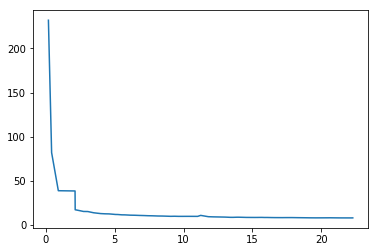

In [19]:
plt.plot(ds,mape)


In [20]:
min(mape)

8.066871460208265

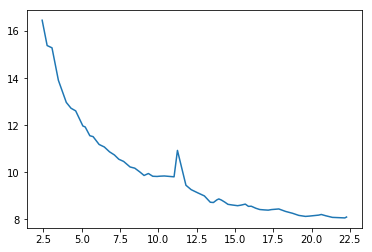

In [21]:
plt.plot(ds[5:],mape[5:])


## Scores for small distances are not very good at all. There are also numerous negative predictions.

Run the whole thing again with more training time

# Try again with more layers

In [27]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['base_time_dep','distance','rain','temp','day'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(100,100,100,100),verbose=True)
                from sklearn.preprocessing import normalize
                
 
            #if mode == 'validate':
            #   if self.regr_type == 'Neural':
                    #self.validate_neural()
            #   else:
                    #self.validate_model()
            #lif mode == 'production':
                #self.build_full_model()
                #self.dump_model()
    def validate_neural(self):
        print('training regressor')
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('Validating...')
        print(metrics.r2_score(self.test_1_Y,preds))
        preds = self.model.predict(self.test_2_X)
        print(metrics.r2_score(self.test_2_Y,preds))
        print('calculated from norms-->')
        preds = preds * self.test_2_norm
        print(metrics.r2_score(self.test_2_real,preds))
        preds = self.model.predict(self.test_3_X)
        print(metrics.r2_score(self.test_3_Y,preds))
    def validate_model(self):
        self.data = self.data[self.data['traveltime']>0] 
        if self.verbose:
            print('Validating model on all trips...\n\n')
        
        self.train = self.data[self.data['year']==2016]
        self.test = self.data[self.data['year']==2017]
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('-----> Tested on all distances')
        print('R2:', metrics.r2_score(self.test_1_Y,preds))
        print('MAE:', metrics.mean_absolute_error(self.test_1_Y,preds)*self.norm[-1])
        print('MAPE:', ((abs(self.test_1_Y-preds)/self.test_1_Y)*100).mean())
        #add more options for testing eventually
        print('Validating model on longest trip')
        test2= self.test[self.test['distance']==self.test['distance'].max()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].max()]
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        print('\n\n Validated on median trip -->')
        test2= self.test[self.test['distance']==self.test['distance'].median()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].median()]
        
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        del(self.train)
        del(self.test)
        del(self.data)
        del(test2)


    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        #if self.use_dummies:
        #    self.add_dummies()
        #    self.features += self.dummy_features
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','routeid','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid','routeid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep'] 
        #A number of rows have negative travel time. But its a really small number, so I guess they 
        #can go in the bin.
        self.data = self.data[self.data['traveltime']>0]
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['dt'].dt.hour
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['day','month','hour'])
        self.dummy_features = [col for col in self.data.columns\
                                if (col[0:3] == 'day' and col != 'dayofservice')\
                                or col[0:5] == 'month' or col[0:4] == 'hour']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [28]:
r = BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather


In [29]:
train = r.data[r.data['year']==2016]
test = r.data[r.data['year']==2017]

In [30]:
from sklearn.preprocessing import StandardScaler as ss

In [31]:
scaler_X = ss()
X = scaler_X.fit_transform(train[r.features])

In [32]:
scaler_Y = ss()
Y = scaler_Y.fit_transform(train['traveltime'].values.reshape(-1,1))

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
model = r.rgr.fit(X,Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.02092782
Iteration 2, loss = 0.01716320
Iteration 3, loss = 0.01662980
Iteration 4, loss = 0.01627127
Iteration 5, loss = 0.01597476
Iteration 6, loss = 0.01568695
Iteration 7, loss = 0.01547221
Iteration 8, loss = 0.01523690
Iteration 9, loss = 0.01504066
Iteration 10, loss = 0.01482985
Iteration 11, loss = 0.01464073
Iteration 12, loss = 0.01441228
Iteration 13, loss = 0.01416399
Iteration 14, loss = 0.01389744
Iteration 15, loss = 0.01366590
Iteration 16, loss = 0.01343824
Iteration 17, loss = 0.01324589
Iteration 18, loss = 0.01311986
Iteration 19, loss = 0.01301773
Iteration 20, loss = 0.01287328
Iteration 21, loss = 0.01277088
Iteration 22, loss = 0.01263656


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### The above model took far too long to build and I just gave up

In [34]:
preds = scaler_Y.inverse_transform(model.predict(X))
((abs(train['traveltime']-preds)/train['traveltime'])*100).mean()

MemoryError: 

In [ ]:
distances = sorted(test['distance'].unique())
ds = []
r2 = []
mape = []
for i in range(0,len(distances)-1):
    distance1 = distances[i]
    distance2 = distances[i+1]
    X = test[(test['distance']>=distance1) & (test['distance'] < distance2)]
    real_Y = X['traveltime']
    X = scaler_X.transform(X[r.features])
    preds =  scaler_Y.inverse_transform(model.predict(X))
    ds.append(distance1)
    from sklearn import metrics
    r2.append(metrics.r2_score(real_Y,preds))
    mape.append(((abs(real_Y - preds)/real_Y)*100).mean())
    print(preds.min())
    
    
